# Expanding Signal Beta Regression

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

import statsmodels.api as sm
from   statsmodels.regression.rolling import RollingOLS

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
from PCSpreadOLS import PCASpreadOLS

In [3]:
def _get_expanding(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df.set_index(
        "date").
        sort_index())
    
    model = (RollingOLS(
        endog     = df_tmp.PX_bps,
        exog      = sm.add_constant(df_tmp.lag_spread),
        expanding = True).
        fit())
    
    df_out = (model.params.rename(columns = {
        "const"     : "alpha",
        "lag_spread": "beta"}).
        merge(right = df_tmp, how = "inner", on = ["date"]).
        sort_index().
        assign(
            lag_beta   = lambda x: x.beta.shift().ewm(span = 30, adjust = False).mean(),
            signal_bps = lambda x: np.sign(x.lag_beta * x.lag_spread) * x.PX_bps).
        dropna())
    
    return df_out

def get_expanding_signal() -> pd.DataFrame: 

    df_out = (PCASpreadOLS().pca_signal().drop(
        columns = ["inflation", "breakeven", "spread"]).
        merge(right = PCASpreadOLS().get_tsy_fut(), how = "inner", on = ["date"]).
        drop(columns = ["PX_rtn", "PX_diff", "PX_cnvx", "PX_dur", "PX_LAST"]).
        assign(
            security  = lambda x: x.security.str.split(" ").str[0],
            group_var = lambda x: x.security + " " + x.input_val + " " + x.variable).
        groupby("group_var").
        apply(_get_expanding).
        drop(columns = ["group_var"]).
        reset_index())
    
    return df_out

df_expanding = get_expanding_signal()

C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encount

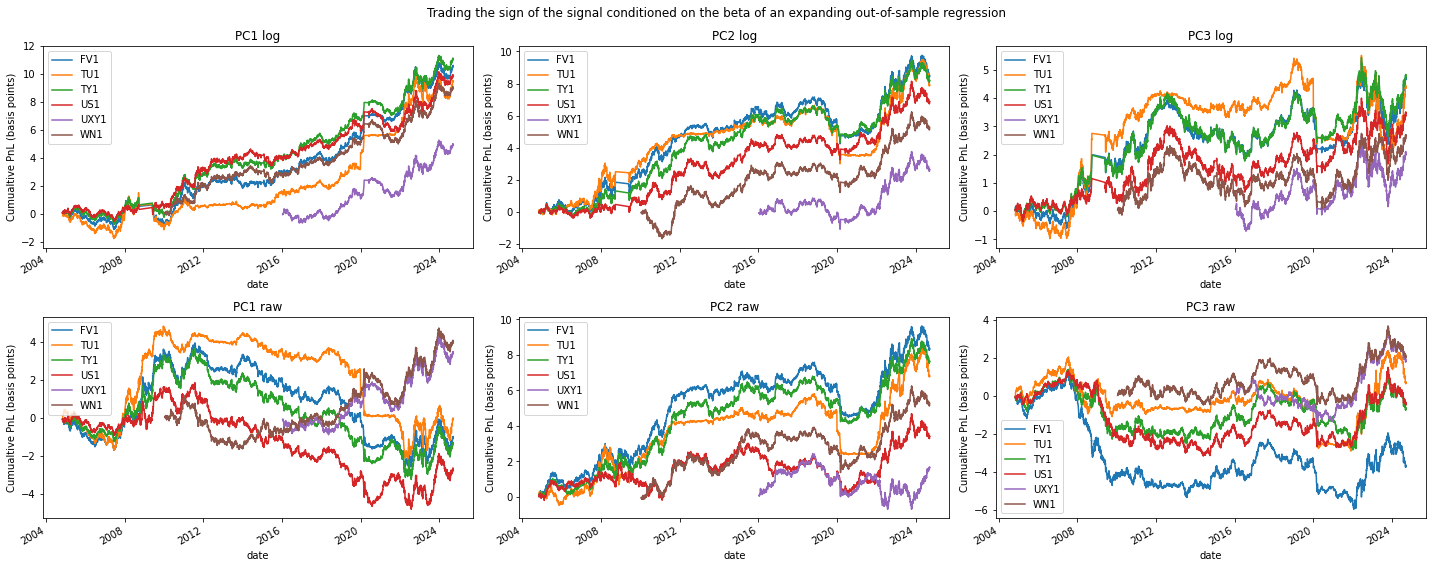

In [4]:
def plot_return(df_expanding: pd.DataFrame) -> plt.Figure:

    df_plot = (df_expanding.drop(
        columns = ["group_var"]).
        assign(group_var = lambda x: x.variable + " " + x.input_val))
    
    group_vars = df_plot.group_var.drop_duplicates().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_plot.query(
            "group_var == @group_var").
            rename(columns = {"security": ""}).
            pivot(index = "date", columns = "", values = "signal_bps").
            cumsum().
            plot(
                ax     = ax,
                title  = group_var.split("_")[0],
                ylabel = "Cumualtive PnL (basis points)"))

    fig.suptitle("Trading the sign of the signal conditioned on the beta of an expanding out-of-sample regression")
    plt.tight_layout()
    
plot_return(df_expanding)

In [5]:
def get_expanding_sharpe(df_expanding: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df_expanding[
        ["input_val", "variable", "security", "signal_bps"]].
        groupby(["input_val", "variable", "security"]).
        agg(["mean", "std"])
        ["signal_bps"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_sharpe = get_expanding_sharpe(df_expanding)

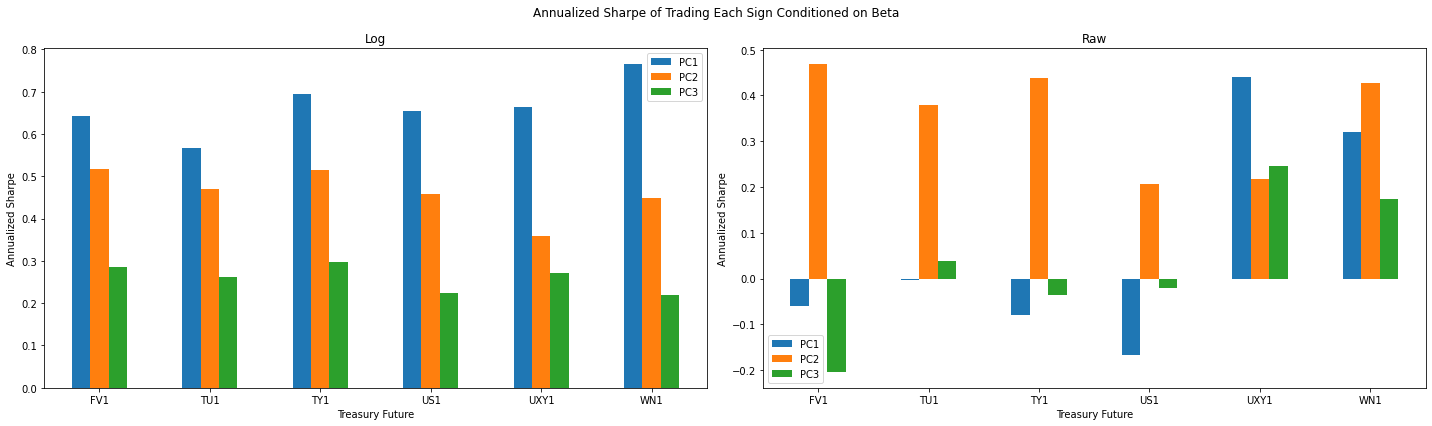

In [6]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure:
    
    variables = df_sharpe.input_val.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    for variable, ax in zip(variables , axes.flatten()):

        (df_sharpe.query(
            "input_val == @variable").
            rename(columns = {"variable": ""}).
            pivot(index = "security", columns = "", values = "sharpe").
            plot(
                kind   = "bar",
                ax     = ax,
                rot    = 0,
                xlabel = "Treasury Future",
                ylabel = "Annualized Sharpe",
                title  = variable.split("_")[0].capitalize()))
        
    fig.suptitle("Annualized Sharpe of Trading Each Sign Conditioned on Beta")
    plt.tight_layout()
    
plot_sharpe(df_sharpe)